<a href="https://colab.research.google.com/github/ReutDanino/Semantic-segmentation-mini-project/blob/main/self_Construction_of_the_UNET_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install

In [1]:
!pip install keras_unet

##Connection to the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import glob
from keras_unet.utils import plot_imgs
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model
from keras_unet.models import custom_unet
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras.models import load_model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from glob import glob as globlib

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


##Paths and sort


In [4]:
NUM_TRAIN_IMAGES = 100
NUM_VAL_IMAGES = 10

# Reading file paths
# Define paths for images and masks for train
image_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/train/CXR_png/*.png"))[:NUM_TRAIN_IMAGES]
mask_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/train/masks/*.png"))[:NUM_TRAIN_IMAGES]

# Define paths for images and masks for validation
image_val_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/validation/CXR_png/*.png"))[:NUM_VAL_IMAGES]
mask_val_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/validation/masks/*.png"))[:NUM_VAL_IMAGES]

# Define paths for images and masks for test
image_test_paths=sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/*.png"))
mask_test_paths=sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/test מחולק/masks/*.png"))

# Example image path for testing
image_path = "/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/CHNCXR_0540_1.png"

##Data preparation

In [5]:
#Number of images in the dataset
num_images = len(image_paths)

#Set width and height for resizing images
width, height = 224,224
#Initialize lists to images and masks
imgs_list = []
masks_list = []

#Load and resize images and masks, then add them to the lists
for image, mask in zip(image_paths, mask_paths):
    imgs_list.append(np.array(Image.open(image).convert("RGB").resize((width, height))))
    # Resize mask
    mask_img = Image.open(mask).resize((width, height))
    masks_list.append(np.array(mask_img))
#Convert lists to numpy arrays
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

#Print the dimensions of the data
print(imgs_np.shape, masks_np.shape)

#Ensure the mask images are binary (black and white)
masks_np = np.where(masks_np > 0, 255, 0)
print(np.unique(imgs_np), np.unique(masks_np))

(100, 224, 224, 3) (100, 224, 224)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237

In [6]:
# Normalize image data for training
x_train = np.asarray(imgs_np, dtype=np.float32)/255
y_train = np.asarray(masks_np, dtype=np.float32)/255
print(x_train.max(), y_train.max())

#Reshape masks to add a channel dimension
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
print(x_train.shape, y_train.shape)

1.0 1.0
(100, 224, 224, 3) (100, 224, 224, 1)


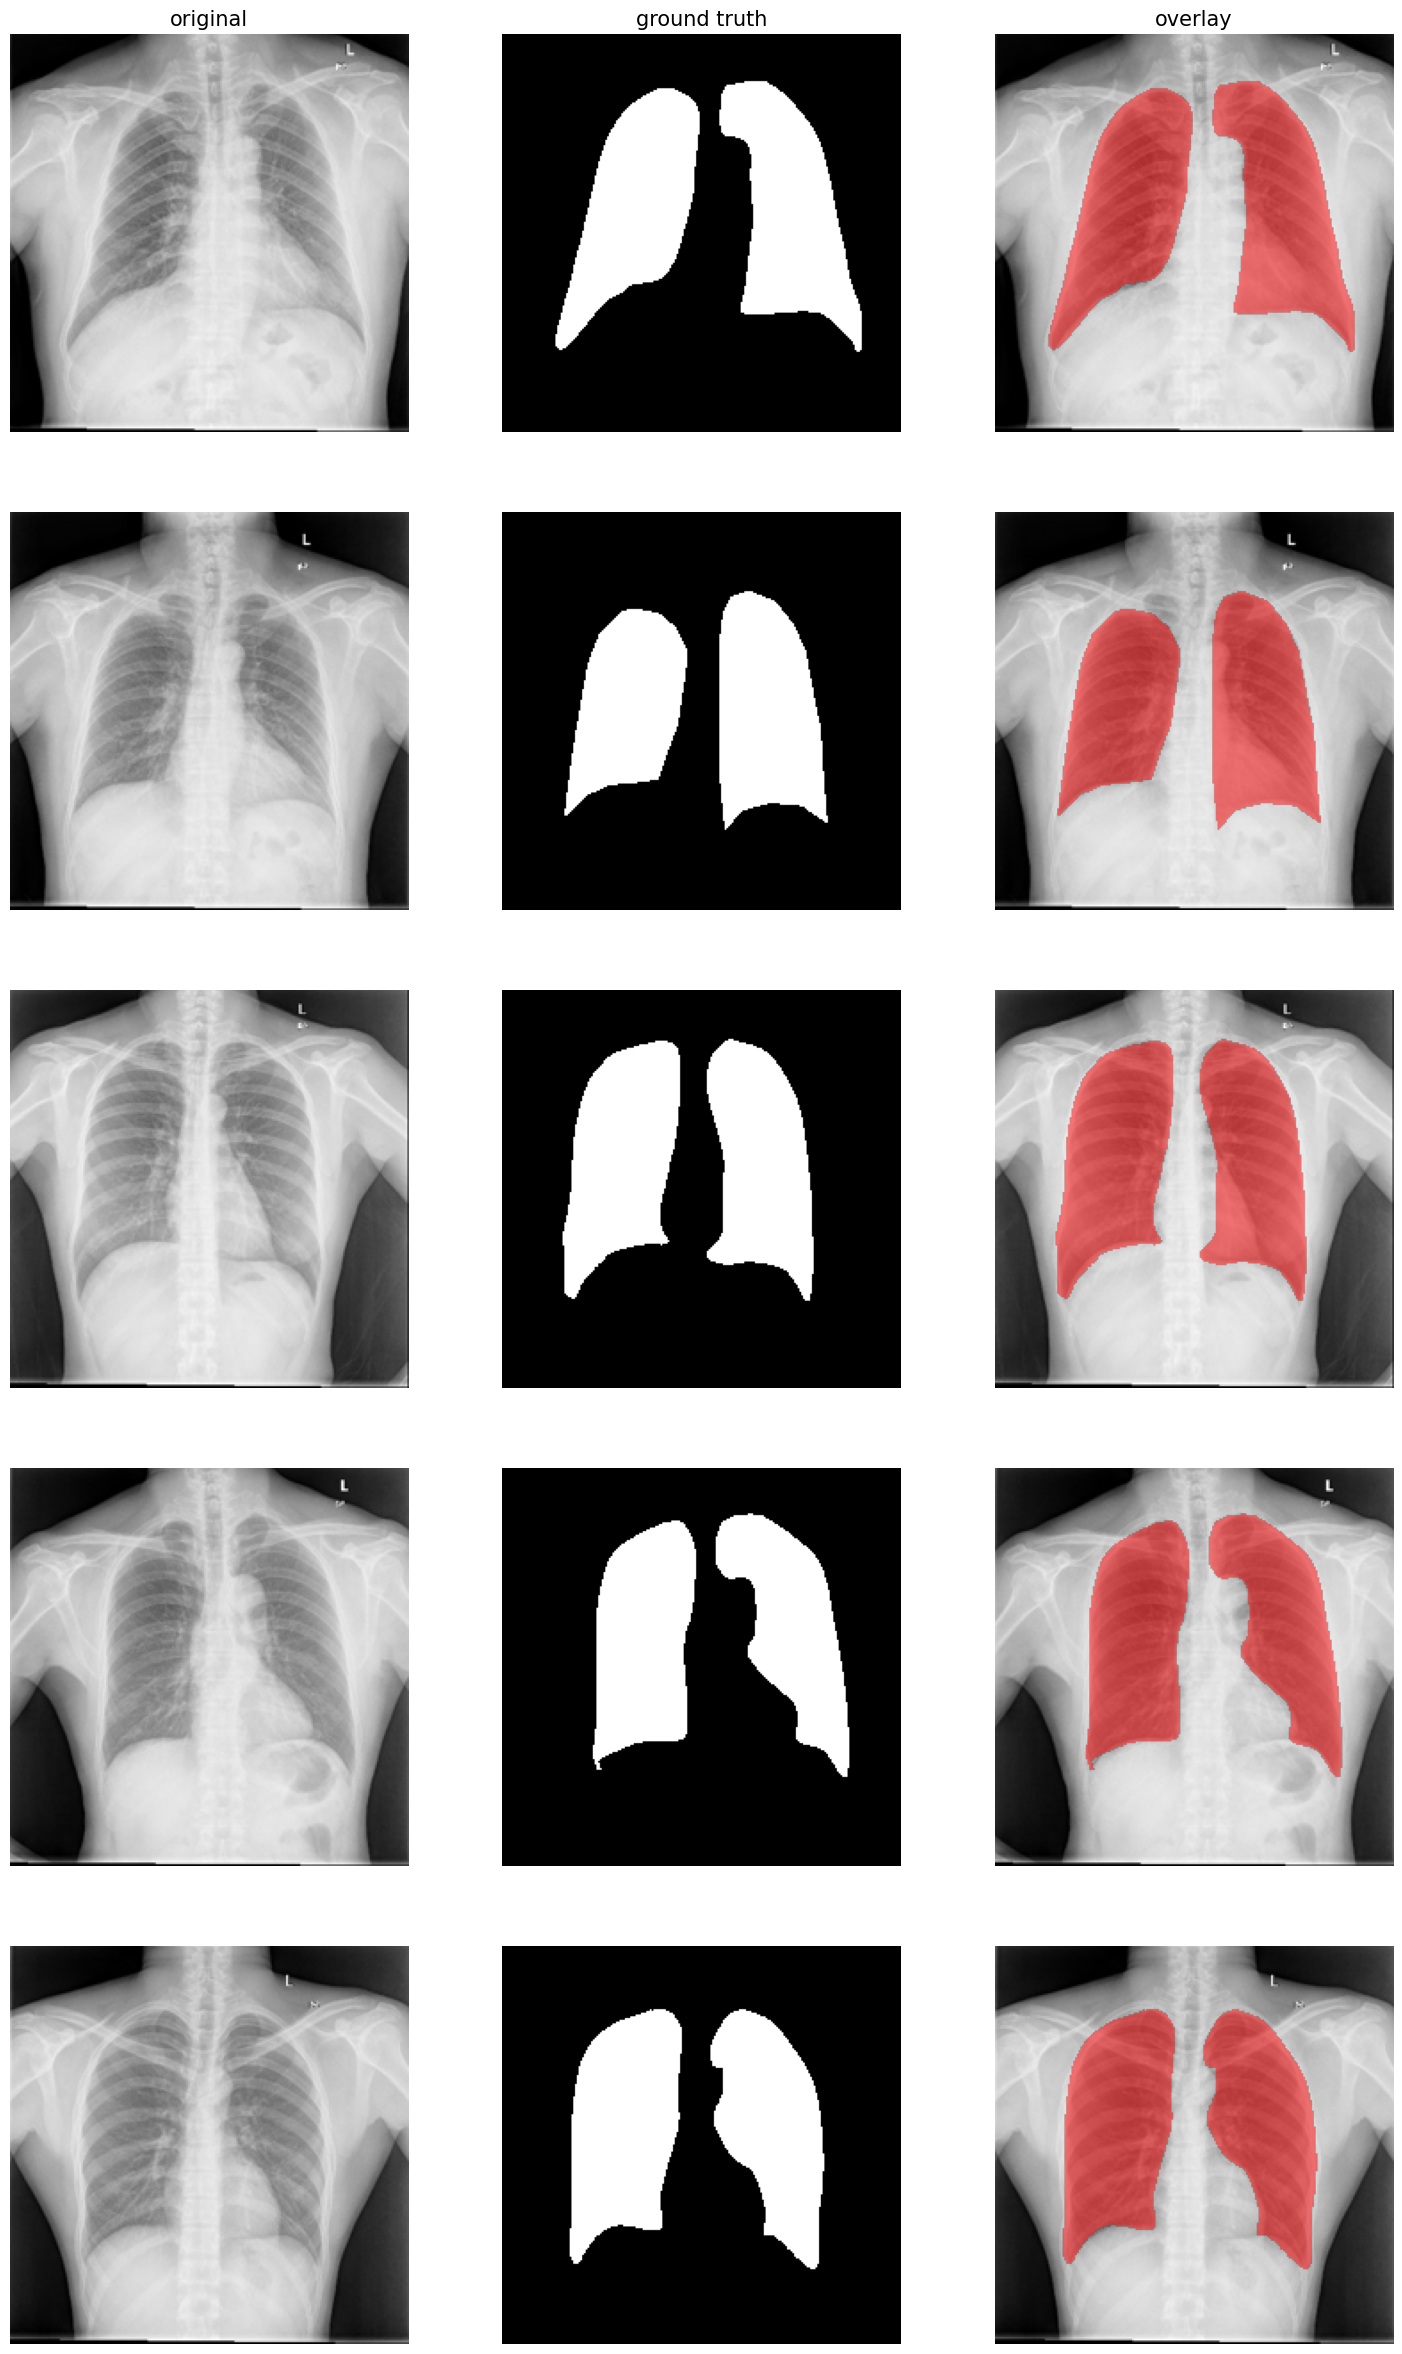

In [7]:
# Display images and their corresponding masks from the train
plot_imgs(org_imgs=x_train, mask_imgs=y_train, nm_img_to_plot=5, figsize=6)

In [8]:
image_val_list=[]
mask_val_list=[]

#Load and resize validation images and masks, then add them to the lists
for image_val, mask_val in zip(image_val_paths, mask_val_paths):
    imgs_list.append(np.array(Image.open(image_val).convert("RGB").resize((width, height)))) #Convert validation image to RGB and resize
    im = Image.open(mask_val).resize((width, height)) # Resize validation mask
    masks_list.append(np.array(im))

#Convert validation lists to numpy arrays
for img_val, mask_val in zip(image_val_paths, mask_val_paths):
    image_val_list.append(np.array(Image.open(img_val).convert("RGB").resize((width, height))))
    im_val = Image.open(mask_val).resize((width, height))
    mask_val_list.append(np.array(im_val))

imgs_np_val = np.asarray(image_val_list)
masks_np_val = np.asarray(mask_val_list)

#Ensure the validation mask images are binary (black and white)
masks_np_val = np.where(masks_np_val > 0, 255, 0)
print(np.unique(imgs_np_val), np.unique(masks_np_val))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [9]:
# Normalize validation images and masks
x_val = np.asarray(imgs_np_val, dtype=np.float32)/255
y_val = np.asarray(masks_np_val, dtype=np.float32)/255
print(x_val.max(), y_val.max())

# Reshape validation masks to add channel dimension
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1)
print(x_val.shape, y_val.shape)

1.0 1.0
(10, 224, 224, 3) (10, 224, 224, 1)


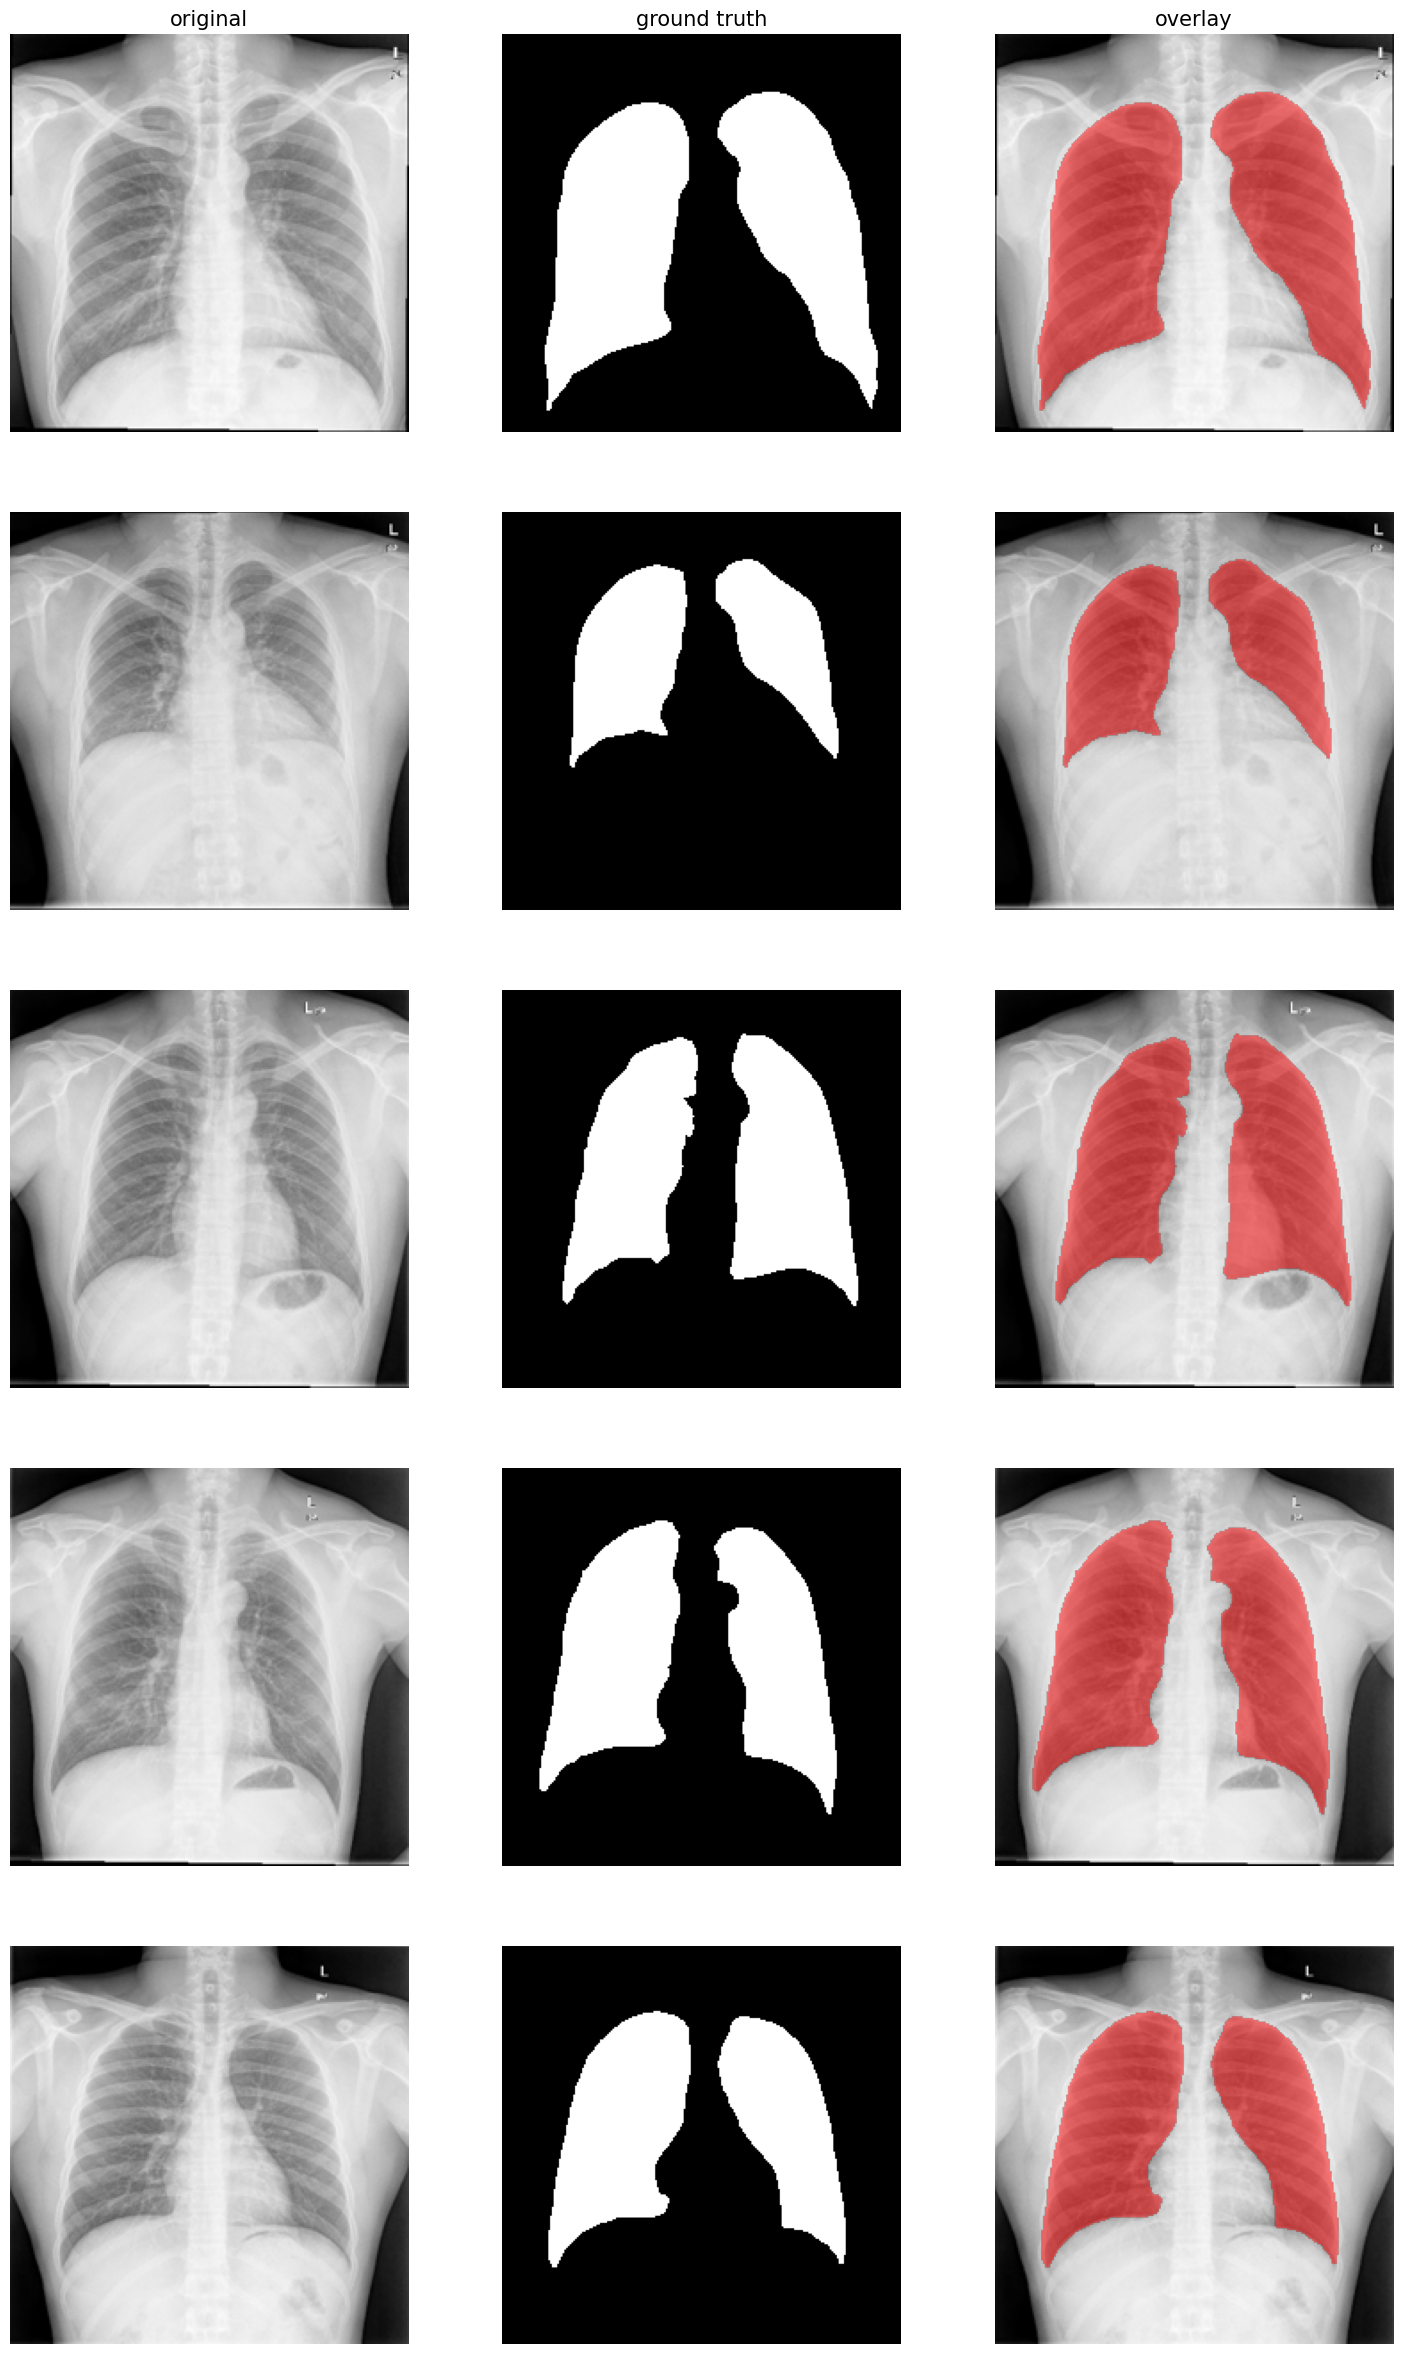

In [10]:
# Display images and their corresponding masks from the validation
plot_imgs(org_imgs=x_val, mask_imgs=y_val, nm_img_to_plot=5, figsize=6)

In [11]:
# Print the shapes of training and validation datasets
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (100, 224, 224, 3)
y_train:  (100, 224, 224, 1)
x_val:  (10, 224, 224, 3)
y_val:  (10, 224, 224, 1)


##Unet network definition.

Selection of programs for the convolution layers, functions and more.

In [ ]:
# Define the UNET network
def our_Unet(input_shape, num_classes):
  inputs = Input(input_shape)
  # Convolutions
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #Pooling

  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

  #UpSampling
  up6 = UpSampling2D(size=(2, 2))(conv5)
  merge1 = Concatenate(axis=3)([conv4, up6]) #Concatenate
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge1)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  up7 = UpSampling2D(size=(2, 2))(conv6)
  merge2 = Concatenate(axis=3)([conv3, up7])
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge2)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  up8 = UpSampling2D(size=(2, 2))(conv7)
  merge3 = Concatenate(axis=3)([conv2, up8])
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  up9 = UpSampling2D(size=(2, 2))(conv8)
  merge4 = Concatenate(axis=3)([conv1, up9])
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge4)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)
  model = Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
#Define input shape based on training data
input_shape = x_train[0].shape

#Initialize the model
model = our_Unet(input_shape,1)

In [ ]:
#Compile the model with optimizer, loss function, and metrics
model.compile(
    optimizer=Adam(learning_rate = 1e-5),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
batch_size=2
steps_per_epoch = max(1, len(x_train) // batch_size)
validation_steps = max(1, len(x_val) // batch_size)

#Train the model
history = model.fit(
    x_train,y_train,
    steps_per_epoch= steps_per_epoch,
    epochs=30,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
)

Epoch 1/30
50/50 [==============================] - 30s 135ms/step - loss: 0.6519 - iou: 0.1811 - iou_thresholded: 4.1534e-05 - val_loss: 0.6048 - val_iou: 0.1533 - val_iou_thresholded: 3.8404e-05
Epoch 2/30
50/50 [==============================] - 6s 124ms/step - loss: 0.5327 - iou: 0.1638 - iou_thresholded: 4.1622e-05 - val_loss: 0.4342 - val_iou: 0.2342 - val_iou_thresholded: 3.8404e-05
Epoch 3/30
50/50 [==============================] - 6s 127ms/step - loss: 0.3670 - iou: 0.2851 - iou_thresholded: 4.1451e-05 - val_loss: 0.3693 - val_iou: 0.3289 - val_iou_thresholded: 3.8404e-05
Epoch 4/30
50/50 [==============================] - 6s 127ms/step - loss: 0.3198 - iou: 0.3434 - iou_thresholded: 0.4591 - val_loss: 0.2923 - val_iou: 0.4270 - val_iou_thresholded: 0.6555
Epoch 5/30
50/50 [==============================] - 6s 126ms/step - loss: 0.2371 - iou: 0.5154 - iou_thresholded: 0.6702 - val_loss: 0.2060 - val_iou: 0.5715 - val_iou_thresholded: 0.7110
Epoch 6/30
50/50 [=================

In [ ]:
#Save the model
model.save('/content/drive/MyDrive/our_model_UNET.h6')

In [ ]:
#Evaluate the model on training data
train_loss, train_iou, train_iou_thresholded = model.evaluate(x_train, y_train, verbose=0, batch_size=2)
print(f'Train Loss: {train_loss:.2f}')
print(f'Train IoU: {train_iou:.2f}')
print(f'Train IoU Thresholded: {train_iou_thresholded:.2f}')

#Evaluate the model on validation data
val_loss, val_iou, val_iou_thresholded = model.evaluate(x_val, y_val, verbose=0, batch_size=2)
print(f'Validation Loss: {val_loss:.2f}')
print(f'Validation IoU: {val_iou:.2f}')
print(f'Validation IoU Thresholded: {val_iou_thresholded:.2f}')

Train Loss: 0.07
Train IoU: 0.83
Train IoU Thresholded: 0.88
Validation Loss: 0.08
Validation IoU: 0.83
Validation IoU Thresholded: 0.88


In [ ]:
# Sort the test image and mask
# Initialize lists to store the test images and masks

num_images_test = len(image_test_paths)
image_test_list = []
mask_test_list = []


# Load and preprocess the test images and masks
for image_test, mask_test in zip(image_test_paths, mask_test_paths):
    # Load and preprocess the test image
    image_test_list.append(np.array(Image.open(image_test).convert("RGB").resize((width, height))))
    # Load and preprocess the test mask
    im_test = Image.open(mask_test).resize((width, height))
    mask_test_list.append(np.array(im_test))


# Convert the lists to numpy arrays
imgs_np_test = np.asarray(image_test_list)
masks_np_test = np.asarray(mask_test_list)

# Binarize the test masks (convert to 0 and 255)
masks_np_test = np.where(masks_np_test > 0, 255, 0)


# Normalize the test images and masks
x_test = np.asarray(imgs_np_test, dtype=np.float32)/255
y_test = np.asarray(masks_np_test, dtype=np.float32)/255


# Reshape the test masks to add the channel dimension
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

# Load the model
#model_path = '/content/drive/MyDrive/our_model_UNET.h6'
#model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})


# Evaluate the model on the test data
test_loss, test_iou, test_iou_thresholded = model.evaluate(x_test, y_test, verbose=0)

# Print the test evaluation results
print(f'Test Loss: {test_loss:.2f}')
print(f'Test IoU: {test_iou:.2f}')
print(f'Test IoU Thresholded: {test_iou_thresholded:.2f}')

Test Loss: 0.09
Test IoU: 0.85
Test IoU Thresholded: 0.89


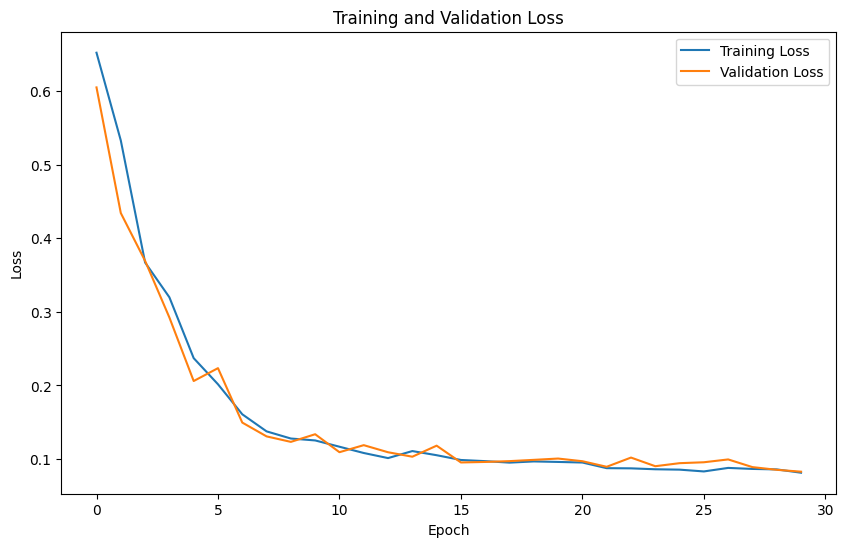

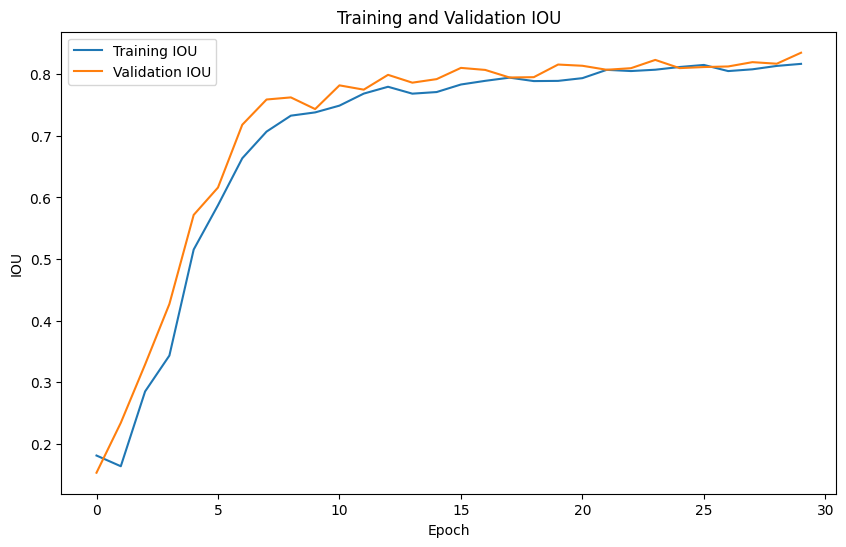

In [ ]:
# Combined plots for training and validation metrics
#loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#iou
plt.figure(figsize=(10, 6))
plt.plot(history.history["iou"], label="Training IOU")
plt.plot(history.history["val_iou"], label="Validation IOU")
plt.title("Training and Validation IOU")
plt.ylabel("IOU")
plt.xlabel("Epoch")
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
Input image shape: (224, 224, 3)
Input image values (min, max): (0.0, 0.92941177)
Predicted mask shape: (224, 224, 1)
Predicted mask values (min, max): (4.738796e-36, 0.99975175)
Binary mask values (unique): [0 1]


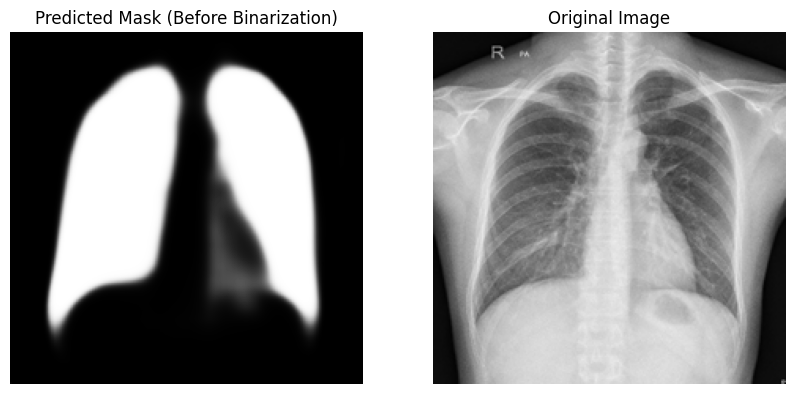

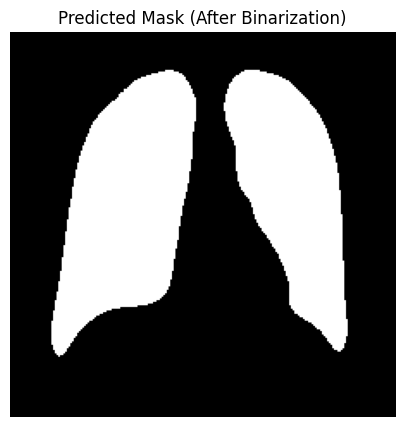

In [ ]:
#Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img_np = np.array(img, dtype=np.float32) / 255.0
    return img_np

#Function to predict and visualize the results
def predict_and_visualize(image_path, target_size, model):
    #Load and preprocess the image
    input_image = load_and_preprocess_image(image_path, target_size)

    #Expand dimensions to fit the model input
    input_image_expanded = np.expand_dims(input_image, axis=0)

    #Predict the mask
    predicted_mask = model.predict(input_image_expanded)[0]

    #Print input image and predicted mask values for verification
    print(f"Input image shape: {input_image.shape}")
    print(f"Input image values (min, max): {input_image.min(), input_image.max()}")
    print(f"Predicted mask shape: {predicted_mask.shape}")
    print(f"Predicted mask values (min, max): {predicted_mask.min(), predicted_mask.max()}")

    #Display predicted mask before binarization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask (Before Binarization)')
    plt.axis('off')

    #Binarize the predicted mask
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    #Print binary mask values for verification
    print(f"Binary mask values (unique): {np.unique(predicted_mask_binary)}")

    #Display the original image
    plt.subplot(1, 2, 2)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    #Display predicted mask after binarization
    plt.figure(figsize=(10, 5))
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask (After Binarization)')
    plt.axis('off')

    plt.show()

#If you need to call the saved model and use it.
#model_path = '/content/drive/MyDrive/our_model_UNET.h6'
#model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})

#Example usage of the function
target_size = (224, 224)  #Setting the size of the image according to the model
predict_and_visualize(image_path, target_size, model)
